# Load libraries

In [1]:
# Reload modules before executing user code
%load_ext autoreload
# Reload all modules every time before executing Python code
%autoreload 2

import os
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

from functools import partial
import concurrent.futures

sys.path.append('..')
from utils_camels_spat import validate_basin_data, plot_missing_data_heatmap

# Constants

In [2]:
dataset = ('CAMELS_spat_NH', 'camels_spat')
# countries = ["USA"]
countries = ["CAN"]

# 'countries' to string and lowercase
countries_str = '-'.join(countries).lower()

NUM_BASINS = 2000
# StartDate = "1975-10-01"
# EndDate = "2019-09-30"
# StartDate = "1980-10-01"
# EndDate = "2008-09-30"
# StartDate = "1980-10-01"
# EndDate = "2010-09-30"
StartDate = "1989-10-01"
EndDate = "2008-09-30"

MULTIPROCESSING = 1

# Load data

In [3]:
# Load 447/531 basins as reference from 447/531_basin_file.txt (list of basins IDs)

# file_ref = "569_basin_file.txt"
file_ref = "531_basin_file.txt"
# file_ref = "447_basin_file.txt"

lines = []
# Open the file in read mode
with open(file_ref , 'r') as file:
    # Read each line and append it to the list
    for line in file:
        lines.append(line.strip())  # Remove any leading/trailing whitespace

# Print the lines to verify
basinNH_ref = set(lines)

## Process Cyril list

In [4]:
cyril_file = 'liste_BV_CAMELS-spat_928.txt'
# Load list of basins
cyril_basins = []
# Open the file in read mode
with open(cyril_file , 'r') as file:
    # Read each line and append it to the list
    for line in file:
        cyril_basins.append(line.strip()[4:])  # Remove any leading/trailing whitespace

# Write all selected basin names to a file named after the counter
with open(f"{len(cyril_basins)}_cyril_basins_can_usa.txt", "w") as f:
    for basin_name in cyril_basins:
        f.write(basin_name.split('.')[0] + "\n")


# Run

In [5]:
# Initialize lists to store basin information
selected_basins = []
df_basins_missing = pd.DataFrame()
counter = 0
counter_not_in_ref = 0
not_to_stop = True
for country in countries:
    data_dir = f"../../../../../gladwell/hydrology/SUMMA/summa-ml-models/{dataset[0]}/CAMELS_spat_{country}"
    basins = sorted(os.listdir(data_dir))

    # # Save file with list of all available basins
    # print(country, len(basins))
    # continue
    
    if MULTIPROCESSING:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # Define a partial function to pass the data_dir
            process_basin_partial = partial(validate_basin_data, data_dir=data_dir, start_date=StartDate, end_date=EndDate)
            
            # Process each basin concurrently
            results = [executor.submit(process_basin_partial, basin) for basin in basins]
            
            # Wait for all results to be available
            for result in concurrent.futures.as_completed(results):
                
                basin, basin_ok, date_presence = result.result()
                
                # Append date_presence to the dataframe
                if date_presence is not None:
                    # df_basins_missing[basin] = date_presence
                    # Create a DataFrame from the basin and date_presence
                    df_to_concat = pd.DataFrame({basin: date_presence})
                    # Concatenate the new DataFrame with df_basins_missing
                    df_basins_missing = pd.concat([df_basins_missing, df_to_concat], axis=1)
                    
                    # Check if the basin is in the reference list
                    basin_id = basin.split('_')[-1]
                    basin_id = basin_id.split('.')[0]
                
                if basin_ok:
                    # print(counter, basin_ok)
                    selected_basins.append(basin)

                    if basin_id not in basinNH_ref:
                        # print(f"Basin {country}_{basin_id} not in the reference list (531)")
                        counter_not_in_ref  += 1
                    
                    counter += 1
                    if counter == NUM_BASINS:
                        break
                else:
                    print(basin, 'basin_ok =', basin_ok, 'is in Cyril list =', basin.split(".")[0] in cyril_basins)
                    
        print(country, len([res for res in results if res.result() is not None]), '->', len(selected_basins), \
            f'| {counter_not_in_ref} not in 531')
        
    else:
        # Initialize lists to store basin information
        for basin in basins[:]:
            # print(counter, basin)
            _, basin_ok, date_presence = validate_basin_data(basin, data_dir, StartDate, EndDate)
            # print(basin_ok, date_presence)
            
            # Append date_presence to the dataframe
            if date_presence is not None:
                df_basins_missing[basin] = date_presence
            
            if basin_ok:
                print(counter, basin)
                selected_basins.append(basin)
                
                counter += 1
                if counter == NUM_BASINS:
                    break

01AF009.csv basin_ok = False is in Cyril list = False
01BU009.csv basin_ok = False is in Cyril list = False
01AP006.csv basin_ok = False is in Cyril list = False
01CD005.csv basin_ok = False is in Cyril list = False
01BD008.csv basin_ok = False is in Cyril list = True
01DJ005.csv basin_ok = False is in Cyril list = False
01BG009.csv basin_ok = False is in Cyril list = True
01AE001.csv basin_ok = False is in Cyril list = True
01AJ010.csv basin_ok = False is in Cyril list = True
01BG008.csv basin_ok = False is in Cyril list = False
01BG005.csv basin_ok = False is in Cyril list = True
01BH005.csv basin_ok = False is in Cyril list = False
02AB021.csv basin_ok = False is in Cyril list = False
01CC005.csv basin_ok = False is in Cyril list = False
01BH010.csv basin_ok = False is in Cyril list = False
01AJ003.csv basin_ok = False is in Cyril list = True
01BV004.csv basin_ok = False is in Cyril list = False
01BP002.csv basin_ok = False is in Cyril list = False
01EE005.csv basin_ok = False is in

In [6]:
# Extract start and end years
start_year = pd.to_datetime(StartDate).year
end_year = pd.to_datetime(EndDate).year

# Write all selected basin names to a file named after the counter
with open(f"{len(selected_basins)}_basin_{dataset[1]}_{start_year}-{end_year}_{countries_str}.txt", "w") as f:
    for basin_name in sorted(selected_basins):
        f.write(basin_name.split('.')[0] + "\n")
    
    # Remove last newline character
    f.seek(f.tell() - 1)
    f.truncate()

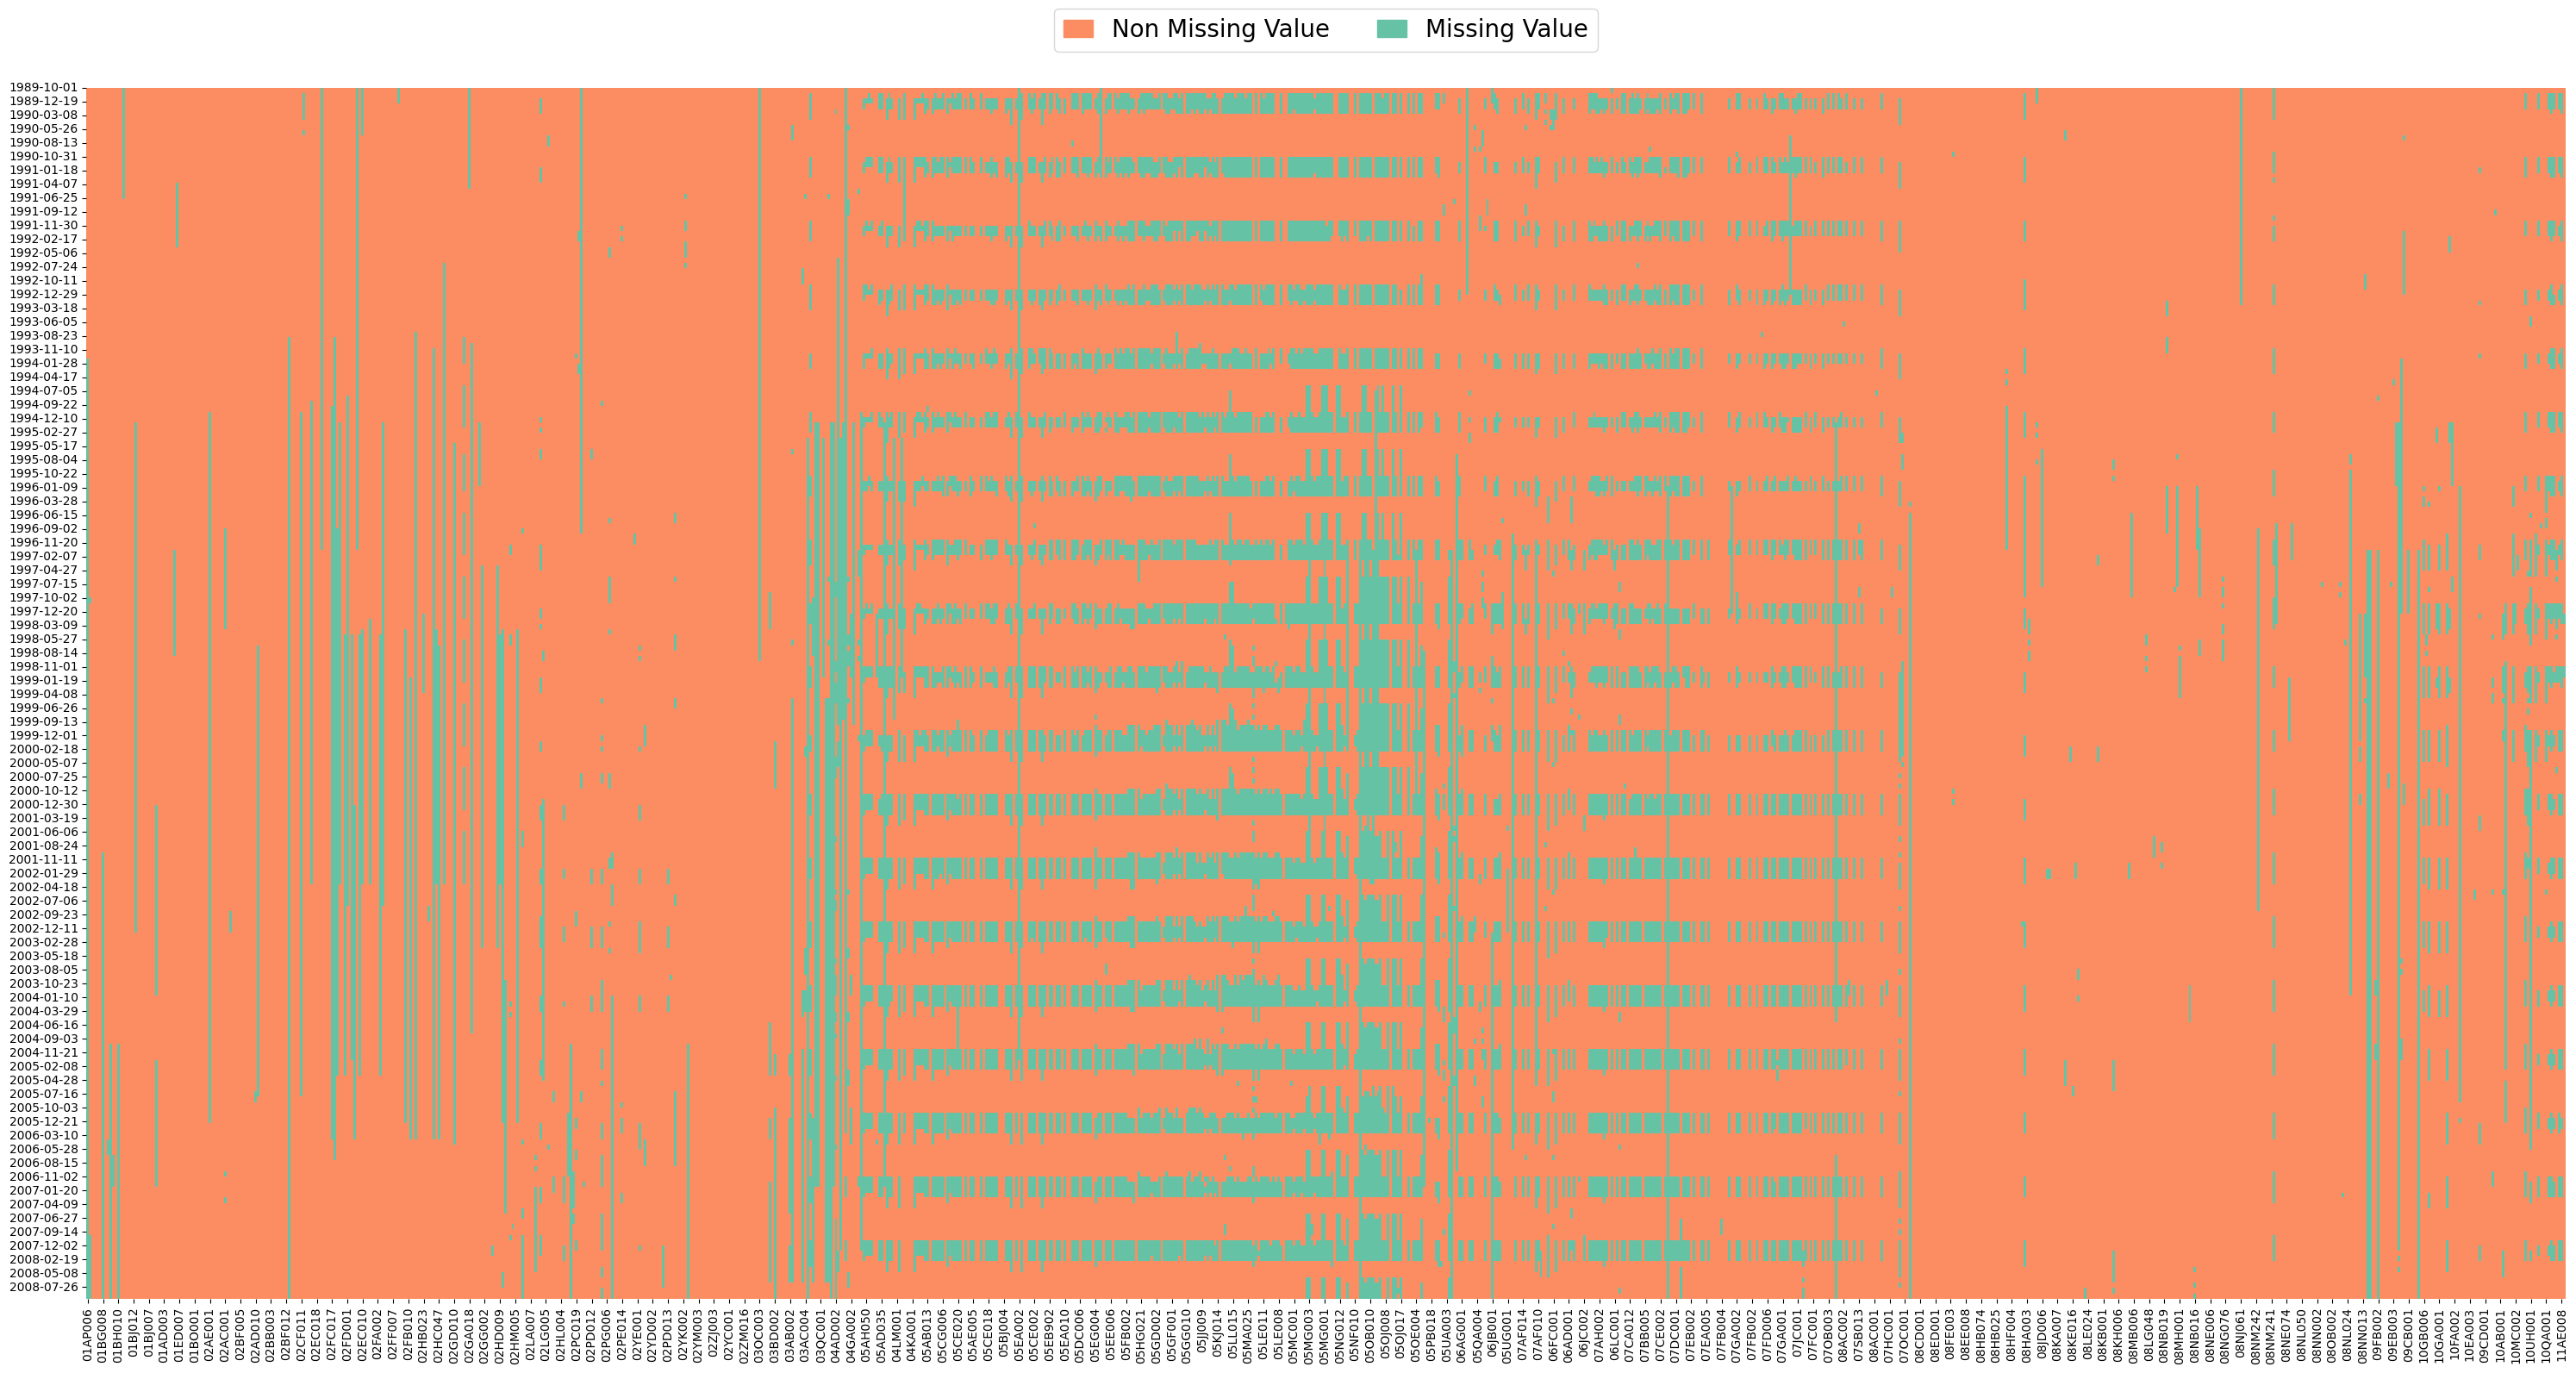

In [7]:
# Rename columns to remove file extension
df_basins_missing.columns = [col.split('.')[0] for col in df_basins_missing.columns]

# Date column to string format and YYYY-MM-DD if needed
if df_basins_missing.index.dtype == 'datetime64[ns]':
    df_basins_missing.index = df_basins_missing.index.strftime('%Y-%m-%d')

plot_missing_data_heatmap(df_basins_missing, dataset, start_year=start_year, end_year=end_year, countries_str=countries_str)